In [1]:
import pandas as pd

df = pd.read_csv('../data/csv/data.csv')

print(df.shape)
df.head()

(1254243, 6)


,CLNT_RMT_IP,ROI_CLICK_EVENT_TS,BRWSR_NAME,ams_pblshr_id,buyer_id,click_id
0,77.111.247.168,2020-08-02 18:37:01,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,valen_949,209245484389035777
1,66.249.73.101,2020-08-21 03:36:38,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586
2,77.111.247.129,2020-08-21 03:36:38,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586
3,66.249.73.101,2020-08-21 03:36:33,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586
4,77.111.247.129,2020-08-21 03:36:33,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586


In [2]:
from user_agents import parse
import pandas as pd
import swifter  # for parallel processing with Pandas (install with `pip install swifter`)

# Dictionary to cache parsed user-agent strings and reduce redundant parsing
user_agent_cache = {}

def extract_user_agent_features_optimized(ua_string):
    # Check if this user-agent string has already been parsed
    if ua_string in user_agent_cache:
        return user_agent_cache[ua_string]
    
    # Parse the user agent string and store parsed results in a variable
    user_agent = parse(ua_string)
    
    # Extract required features
    result = {
        'browser': user_agent.browser.family,
        # 'browser_version': user_agent.browser.version_string,
        'os': user_agent.os.family,
        # 'os_version': user_agent.os.version_string,
        'device_type': (
    'mobile' if user_agent.is_mobile else
    'desktop' if user_agent.is_pc else
    'tablet' if user_agent.is_tablet else
    'bot' if user_agent.is_bot else 'other'
        )
    }
    
    # Store result in the cache
    user_agent_cache[ua_string] = result
    
    return result

# Apply optimized function to the user-agent column with parallel processing using swifter
df_user_agent_features = df['BRWSR_NAME'].swifter.apply(extract_user_agent_features_optimized).apply(pd.Series)
df = pd.concat([df, df_user_agent_features], axis=1)
df = df.drop('BRWSR_NAME', axis=1)
def categorize_browser(browser_column):
    # Define the browsers to keep based on the 10,000 row threshold
    popular_browsers = ['Chrome Mobile', 'Chrome', 'Mobile Safari', 'Mobile Safari UI/WKWebView', 'Edge', 'Firefox', 'Samsung Internet', 'Safari', 'Google', 'Chrome Mobile', 'Opera', 'FacebookBot', 'Facebook', 'ImagesiftBot']

    # Apply the categorization
    browser_column = browser_column.apply(lambda x: x if x in popular_browsers else 'Other')
    return browser_column

# Function to categorize OS based on the 1% rule and keeping till Ubuntu
def categorize_os(os_column):
    # Define the OSes to keep based on the row threshold (up to Ubuntu)
    popular_os = ['Android', 'Other', 'iOS', 'Windows', 'Mac OS X', 'Linux', 'Ubuntu', 'Chrome OS']

    # Apply the categorization
    os_column = os_column.apply(lambda x: x if x in popular_os else 'Other')
    return os_column

# Apply categorization functions to the DataFrame
df['browser'] = categorize_browser(df['browser'])
df['os'] = categorize_os(df['os'])

# Display the transformed DataFrame
print(df)

Pandas Apply:   0%|          | 0/1254243 [00:00<?, ?it/s]

             CLNT_RMT_IP   ROI_CLICK_EVENT_TS  ams_pblshr_id      buyer_id  \
0         77.111.247.168  2020-08-02 18:37:01     5574672411     valen_949   
1          66.249.73.101  2020-08-21 03:36:38     5574672411    morbanisaf   
2         77.111.247.129  2020-08-21 03:36:38     5574672411    morbanisaf   
3          66.249.73.101  2020-08-21 03:36:33     5574672411    morbanisaf   
4         77.111.247.129  2020-08-21 03:36:33     5574672411    morbanisaf   
...                  ...                  ...            ...           ...   
1254238   172.226.114.69  2024-09-05 11:04:49     5575612316         srw38   
1254239  208.115.224.233  2024-09-29 06:41:18     5575532731  katzenklo_16   
1254240   138.199.29.213  2024-10-09 03:15:37     5575319207      guyver13   
1254241  172.225.240.192  2024-10-27 03:30:27     5575376664    winde_-129   
1254242   172.226.114.83  2024-11-03 04:57:09     5575791307     monika_pl   

                   click_id                     browser       o

In [3]:
import re
import socket
import struct
from sklearn.preprocessing import OneHotEncoder


# Function to check if the IP address is valid
def is_valid_ipv4(ip):
    if pd.isna(ip):  # Check for None or NaN
        return False
    pattern = r'^(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$'
    return re.match(pattern, ip) is not None

# Apply the function and create a mask for valid IP addresses
valid_ips_mask = df['CLNT_RMT_IP'].apply(is_valid_ipv4)

# Drop rows with invalid IP addresses
df = df[valid_ips_mask]



# 1. Convert IP to integer
def ipv4_to_int(ip):
    return struct.unpack("!I", socket.inet_aton(ip))[0]

df['ip_as_int'] = df['CLNT_RMT_IP'].apply(ipv4_to_int)
df['ROI_CLICK_EVENT_TS'] = pd.to_datetime(df['ROI_CLICK_EVENT_TS'])


# 3. Extract features from datetime
df['year'] = df['ROI_CLICK_EVENT_TS'].dt.year
df['month'] = df['ROI_CLICK_EVENT_TS'].dt.month
df['day'] = df['ROI_CLICK_EVENT_TS'].dt.day
df['hour'] = df['ROI_CLICK_EVENT_TS'].dt.hour
df['minute'] = df['ROI_CLICK_EVENT_TS'].dt.minute
df['second'] = df['ROI_CLICK_EVENT_TS'].dt.second
df['day_of_week'] = df['ROI_CLICK_EVENT_TS'].dt.dayofweek  # Monday=0, Sunday=6

In [5]:
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import StandardScaler



# Step 1: Generate all possible combinations of 'CLNT_RMT_IP', 'ams_pblshr_id', 'buyer_id'
columns = ['CLNT_RMT_IP', 'ams_pblshr_id', 'buyer_id']
combinations_list = []

# Add single column combinations
for i in range(1, len(columns) + 1):
    combinations_list.extend(combinations(columns, i))

# Step 2: Group by each combination and get the count of 'click_id'
result_list = []
for comb in combinations_list:
    grouped = df.groupby(list(comb)).size().reset_index(name=f'click_count_{"+".join(comb)}')
    result_list.append(grouped)
print(len(result_list))

# Step 3: Merge all grouped results back into the original dataframe
merged_df = df.copy()
for result in result_list:
    merged_df = pd.merge(merged_df, result, how='left', on=list(result.columns[:-1]))  # Exclude 'click_count'

# Step 4: Handle missing values (if any) and fill them with 0 or another appropriate value
merged_df.fillna(0, inplace=True)

click_count_columns = [col for col in merged_df.columns if col.startswith('click_count')]

# Step 6: Apply scaling to the 'click_count' columns
scaler = StandardScaler()
merged_df[click_count_columns] = scaler.fit_transform(merged_df[click_count_columns])

# Output the final DataFrame with scaled features
print("DataFrame with Scaled Click Count Features:")
print(merged_df)


7
DataFrame with Scaled Click Count Features:
             CLNT_RMT_IP  ROI_CLICK_EVENT_TS  ams_pblshr_id      buyer_id  \
0         77.111.247.168 2020-08-02 18:37:01     5574672411     valen_949   
1          66.249.73.101 2020-08-21 03:36:38     5574672411    morbanisaf   
2         77.111.247.129 2020-08-21 03:36:38     5574672411    morbanisaf   
3          66.249.73.101 2020-08-21 03:36:33     5574672411    morbanisaf   
4         77.111.247.129 2020-08-21 03:36:33     5574672411    morbanisaf   
...                  ...                 ...            ...           ...   
1254238   172.226.114.69 2024-09-05 11:04:49     5575612316         srw38   
1254239  208.115.224.233 2024-09-29 06:41:18     5575532731  katzenklo_16   
1254240   138.199.29.213 2024-10-09 03:15:37     5575319207      guyver13   
1254241  172.225.240.192 2024-10-27 03:30:27     5575376664    winde_-129   
1254242   172.226.114.83 2024-11-03 04:57:09     5575791307     monika_pl   

                   click_id  

In [7]:
publisher_frequency = merged_df['ams_pblshr_id'].value_counts()
merged_df['ams_pblshr_id_encoded'] = merged_df['ams_pblshr_id'].map(publisher_frequency)

# Frequency Encoding for 'buyer_id' (Buyer ID)
buyer_frequency = merged_df['buyer_id'].value_counts()
merged_df['buyer_id_encoded'] = merged_df['buyer_id'].map(buyer_frequency)

ip_frequency = merged_df['CLNT_RMT_IP'].value_counts()
merged_df['ip_encoded'] = merged_df['CLNT_RMT_IP'].map(ip_frequency)


In [8]:
merged_df.head()

,CLNT_RMT_IP,ROI_CLICK_EVENT_TS,ams_pblshr_id,buyer_id,click_id,browser,os,device_type,ip_as_int,year,...,click_count_CLNT_RMT_IP,click_count_ams_pblshr_id,click_count_buyer_id,click_count_CLNT_RMT_IP+ams_pblshr_id,click_count_CLNT_RMT_IP+buyer_id,click_count_ams_pblshr_id+buyer_id,click_count_CLNT_RMT_IP+ams_pblshr_id+buyer_id,ams_pblshr_id_encoded,buyer_id_encoded,ip_encoded
0,77.111.247.168,2020-08-02 18:37:01,5574672411,valen_949,209245484389035777,Opera,Windows,desktop,1299183528,2020,...,0.094327,2.08812,-0.218090,0.183951,-0.198287,-0.203267,-0.186461,185275,1,2172
1,66.249.73.101,2020-08-21 03:36:38,5574672411,morbanisaf,209453736892211586,Opera,Windows,desktop,1123633509,2020,...,-0.438712,2.08812,-0.214557,-0.267096,-0.197360,-0.199484,-0.185466,185275,5,91
2,77.111.247.129,2020-08-21 03:36:38,5574672411,morbanisaf,209453736892211586,Opera,Windows,desktop,1299183489,2020,...,0.090485,2.08812,-0.214557,0.188008,-0.197360,-0.199484,-0.185466,185275,5,2157
3,66.249.73.101,2020-08-21 03:36:33,5574672411,morbanisaf,209453736892211586,Opera,Windows,desktop,1123633509,2020,...,-0.438712,2.08812,-0.214557,-0.267096,-0.197360,-0.199484,-0.185466,185275,5,91
4,77.111.247.129,2020-08-21 03:36:33,5574672411,morbanisaf,209453736892211586,Opera,Windows,desktop,1299183489,2020,...,0.090485,2.08812,-0.214557,0.188008,-0.197360,-0.199484,-0.185466,185275,5,2157


In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Columns to apply PCA on
cols = [
    'click_count_CLNT_RMT_IP', 'click_count_ams_pblshr_id', 'click_count_buyer_id',
    'click_count_CLNT_RMT_IP+ams_pblshr_id', 'click_count_CLNT_RMT_IP+buyer_id',
    'click_count_ams_pblshr_id+buyer_id', 'click_count_CLNT_RMT_IP+ams_pblshr_id+buyer_id'
]

# Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(merged_df[cols])

# Apply PCA
pca = PCA(n_components=2)  # Retain only the top 2 components
X_pca = pca.fit_transform(merged_df[cols])

# Replace original features in the DataFrame with PCA components
# Create a DataFrame for the PCA components
pca_columns = [f'PCA_Component_{i+1}' for i in range(X_pca.shape[1])]
pca_df = pd.DataFrame(X_pca, columns=pca_columns, index=merged_df.index)

# Drop original columns and add PCA components
merged_df.drop(columns=cols, inplace=True)  # Remove original columns
merged_df = pd.concat([merged_df, pca_df], axis=1)  # Add PCA components

# Check the updated DataFrame
print(merged_df.head())


      CLNT_RMT_IP  ROI_CLICK_EVENT_TS  ams_pblshr_id    buyer_id  \
0  77.111.247.168 2020-08-02 18:37:01     5574672411   valen_949   
1   66.249.73.101 2020-08-21 03:36:38     5574672411  morbanisaf   
2  77.111.247.129 2020-08-21 03:36:38     5574672411  morbanisaf   
3   66.249.73.101 2020-08-21 03:36:33     5574672411  morbanisaf   
4  77.111.247.129 2020-08-21 03:36:33     5574672411  morbanisaf   

             click_id browser       os device_type   ip_as_int  year  ...  \
0  209245484389035777   Opera  Windows     desktop  1299183528  2020  ...   
1  209453736892211586   Opera  Windows     desktop  1123633509  2020  ...   
2  209453736892211586   Opera  Windows     desktop  1299183489  2020  ...   
3  209453736892211586   Opera  Windows     desktop  1123633509  2020  ...   
4  209453736892211586   Opera  Windows     desktop  1299183489  2020  ...   

   day  hour  minute  second  day_of_week  ams_pblshr_id_encoded  \
0    2    18      37       1            6                 18

In [ ]:
features = merged_df[['ams_pblshr_id_encoded', 'buyer_id_encoded', 'ip_encoded']]

# Standardize the features (scaling)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

merged_df[['ams_pblshr_id_encoded', 'buyer_id_encoded', 'ip_encoded']] = features_scaled


,CLNT_RMT_IP,ROI_CLICK_EVENT_TS,ams_pblshr_id,buyer_id,click_id,browser,os,device_type,ip_as_int,year,...,day,hour,minute,second,day_of_week,ams_pblshr_id_encoded,buyer_id_encoded,ip_encoded,PCA_Component_1,PCA_Component_2
0,77.111.247.168,2020-08-02 18:37:01,5574672411,valen_949,209245484389035777,Opera,Windows,desktop,1299183528,2020,...,2,18,37,1,6,2.08812,-0.218090,0.094327,-0.240420,2.075330
1,66.249.73.101,2020-08-21 03:36:38,5574672411,morbanisaf,209453736892211586,Opera,Windows,desktop,1123633509,2020,...,21,3,36,38,4,2.08812,-0.214557,-0.438712,-0.614329,1.849818
2,77.111.247.129,2020-08-21 03:36:38,5574672411,morbanisaf,209453736892211586,Opera,Windows,desktop,1299183489,2020,...,21,3,36,38,4,2.08812,-0.214557,0.090485,-0.236416,2.074432
3,66.249.73.101,2020-08-21 03:36:33,5574672411,morbanisaf,209453736892211586,Opera,Windows,desktop,1123633509,2020,...,21,3,36,33,4,2.08812,-0.214557,-0.438712,-0.614329,1.849818
4,77.111.247.129,2020-08-21 03:36:33,5574672411,morbanisaf,209453736892211586,Opera,Windows,desktop,1299183489,2020,...,21,3,36,33,4,2.08812,-0.214557,0.090485,-0.236416,2.074432


In [12]:
merged_df.columns

Index(['CLNT_RMT_IP', 'ROI_CLICK_EVENT_TS', 'ams_pblshr_id', 'buyer_id',
       'click_id', 'browser', 'os', 'device_type', 'ip_as_int', 'year',
       'month', 'day', 'hour', 'minute', 'second', 'day_of_week',
       'ams_pblshr_id_encoded', 'buyer_id_encoded', 'ip_encoded',
       'PCA_Component_1', 'PCA_Component_2'],
      dtype='object')

In [20]:
from sklearn.cluster import KMeans

# Columns to use for clustering
clustering_columns = [
    'ams_pblshr_id_encoded', 'buyer_id_encoded', 'ip_encoded',
    'PCA_Component_1', 'PCA_Component_2'
]
    # 'year', 'month', 'day', 'hour', 'minute', 'second', 'day_of_week',

# Extract the data for clustering
clustering_data = merged_df[clustering_columns]

# Apply KMeans clustering
n_clusters = 2  # Choose the number of clusters (adjust as needed)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
merged_df['Cluster_Label'] = kmeans.fit_predict(clustering_data)

# Check the updated DataFrame
print(merged_df[['Cluster_Label'] + clustering_columns].head())


   Cluster_Label  ams_pblshr_id_encoded  buyer_id_encoded  ip_encoded  \
0              0                2.08812         -0.218090    0.094327   
1              0                2.08812         -0.214557   -0.438712   
2              0                2.08812         -0.214557    0.090485   
3              0                2.08812         -0.214557   -0.438712   
4              0                2.08812         -0.214557    0.090485   

   PCA_Component_1  PCA_Component_2  
0        -0.240420         2.075330  
1        -0.614329         1.849818  
2        -0.236416         2.074432  
3        -0.614329         1.849818  
4        -0.236416         2.074432  


In [21]:
# Select the desired columns
columns_to_save = [
    'Cluster_Label',  # Add the cluster labels
    'CLNT_RMT_IP', 'ROI_CLICK_EVENT_TS', 'ams_pblshr_id', 'buyer_id',
       'click_id',
]

# Filter the DataFrame
df_to_save = merged_df[columns_to_save]

# Save the selected columns to a CSV file
output_path = '../data/csv/selected_columns_with_clusters2.csv'  # Specify your file path
df_to_save.to_csv(output_path, index=False)

print(f"DataFrame with selected columns saved to '{output_path}'")


DataFrame with selected columns saved to '../data/csv/selected_columns_with_clusters2.csv'


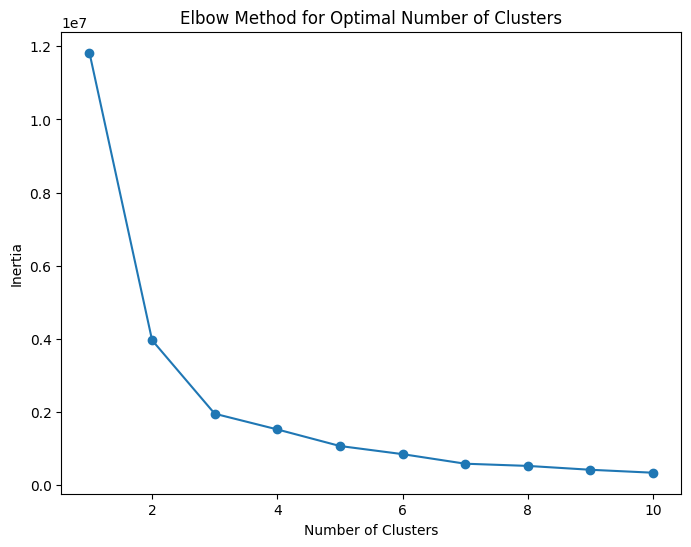

In [23]:
import matplotlib.pyplot as plt

# Elbow method to find the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


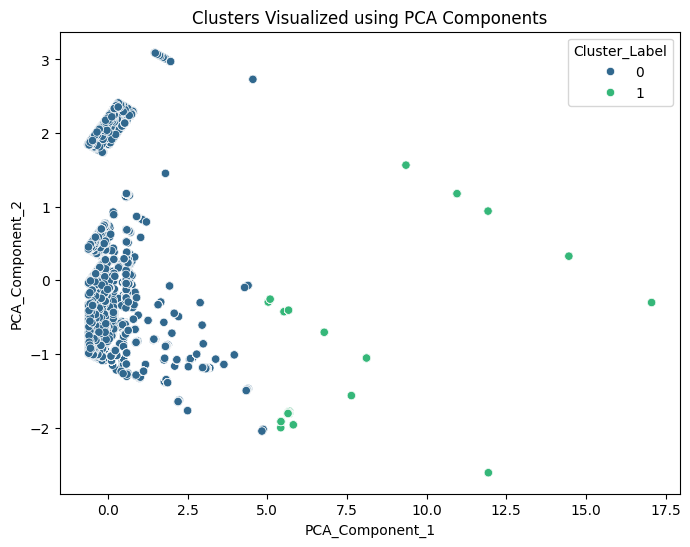

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the first two PCA components with cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PCA_Component_1', 
    y='PCA_Component_2', 
    hue='Cluster_Label', 
    data=merged_df,
    palette='viridis'
)
plt.title('Clusters Visualized using PCA Components')
plt.show()


In [1]:
import pandas as pd 


df = pd.read_csv('../data/csv/clustering_results_on_click_data.csv')

In [2]:
df.head()

,Is_fraud,CLNT_RMT_IP,ROI_CLICK_EVENT_TS,ams_pblshr_id,buyer_id,click_id
0,0,77.111.247.168,2020-08-02 18:37:01,5574672411,valen_949,209245484389035777
1,0,66.249.73.101,2020-08-21 03:36:38,5574672411,morbanisaf,209453736892211586
2,0,77.111.247.129,2020-08-21 03:36:38,5574672411,morbanisaf,209453736892211586
3,0,66.249.73.101,2020-08-21 03:36:33,5574672411,morbanisaf,209453736892211586
4,0,77.111.247.129,2020-08-21 03:36:33,5574672411,morbanisaf,209453736892211586


In [3]:
fraud_df = df[df['Is_fraud'] == 1]

# Group by buyer_id and fetch associated IPs
result = fraud_df.groupby('buyer_id')['CLNT_RMT_IP'].unique()

# Write to a txt file
with open('../data/txt/high_risk_fraud_ips.txt', 'w') as f:
    for buyer_id, ips in result.items():
        f.write(f"Buyer ID: {buyer_id}\n")
        f.write("IPs:\n")
        f.write("\n".join(ips) + "\n")
        f.write("\n")


In [10]:
fraud_buyer_ids = df[df['Is_fraud'] == 1]['buyer_id'].unique()

non_fraud_df = df[(df['Is_fraud'] == 0) & (df['buyer_id'].isin(fraud_buyer_ids))]

# Group by buyer_id and fetch associated IPs
result_non_fraud = non_fraud_df.groupby('buyer_id')['CLNT_RMT_IP'].unique()

# Write to a txt file
with open('../data/txt/mid_risk_fraud_ips.txt', 'w') as f:
    for buyer_id, ips in result_non_fraud.items():
        f.write(f"Buyer ID: {buyer_id}\n")
        f.write("Non-Fraud IPs:\n")
        f.write("\n".join(ips) + "\n")
        f.write("\n")


In [9]:
result

buyer_id
alphaseeker                                      [155.94.160.29]
ndeals100                                        [155.94.160.29]
ndeals60                                         [155.94.160.29]
ndeals80       [155.94.160.29, 66.249.79.228, 66.249.79.199, ...
ndeals90                                         [155.94.160.29]
supenko2                                           [45.82.71.29]
timhu_11                                         [45.32.194.187]
Name: CLNT_RMT_IP, dtype: object